# Monte Carlo Walk-Forward Validation - HYBRID (Local + QC)

**This notebook runs BOTH locally and in QuantConnect Research**

## How it works:
- **Local**: Mocks QuantConnect imports, uses synthetic data
- **QC Research**: Uses real QuantConnect APIs (when implemented)

## Run Locally:
```bash
jupyter notebook monte_carlo_walkforward_HYBRID.ipynb
```

## Run in QC:
1. Upload to QC Research
2. Run all cells
3. When ready: Enable real optimization/backtest calls

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from collections import Counter
import json
import time

# Try to import QuantConnect (will work in QC Research, fail locally)
try:
    from QuantConnect import *
    from QuantConnect.Research import QuantBook
    
    # Initialize QuantBook
    qb = QuantBook()
    IS_LOCAL = False
    print("[OK] QuantConnect Research environment initialized")
    
except ImportError:
    # Mock QuantConnect classes for local testing
    class QuantBook:
        def __init__(self):
            self.project_id = 26129044
    
    qb = QuantBook()
    IS_LOCAL = True
    print("[OK] LOCAL MODE: QuantConnect mocked, using synthetic data")
    print("     (To run in QC Research, upload this notebook to your project)")

[OK] LOCAL MODE: QuantConnect mocked, using synthetic data
     (To run in QC Research, upload this notebook to your project)


In [2]:
# ==================== CONFIGURATION ====================

config = {
    # Your QuantConnect project ID
    'project_id': 26129044,  # Momentum Breakout Strategy
    
    # Total period for analysis
    'total_period': {
        'start': datetime(2023, 1, 1),
        'end': datetime(2024, 12, 31)
    },
    
    # Train/test split (60% train, 40% test)
    'train_test_split': 0.60,
    
    # Number of Monte Carlo runs
    'monte_carlo_runs': 10,
    
    # Parameters to optimize
    'parameters': {
        'lookback_period': {'min': 15, 'max': 25, 'step': 5},
        'volume_multiplier': {'min': 1.3, 'max': 1.7, 'step': 0.2}
    },
    
    # Synthetic data settings (for local testing)
    'synthetic': {
        'train_sharpe_mean': 1.5,
        'train_sharpe_std': 0.3,
        'degradation_mean': 0.20,
        'degradation_std': 0.10
    },
    
    # Random seed for reproducibility
    'random_seed': 42
}

# Set random seed
if config['random_seed'] is not None:
    random.seed(config['random_seed'])
    np.random.seed(config['random_seed'])

print("Configuration:")
print(f"  Mode: {'LOCAL (synthetic data)' if IS_LOCAL else 'QUANTCONNECT RESEARCH'}")
print(f"  Project ID: {config['project_id']}")
print(f"  Period: {config['total_period']['start'].date()} to {config['total_period']['end'].date()}")
print(f"  Train/Test: {config['train_test_split']*100:.0f}%/{(1-config['train_test_split'])*100:.0f}%")
print(f"  Monte Carlo runs: {config['monte_carlo_runs']}")
print(f"  Parameters: {list(config['parameters'].keys())}")

Configuration:
  Mode: LOCAL (synthetic data)
  Project ID: 26129044
  Period: 2023-01-01 to 2024-12-31
  Train/Test: 60%/40%
  Monte Carlo runs: 10
  Parameters: ['lookback_period', 'volume_multiplier']


In [3]:
# ==================== HELPER FUNCTIONS ====================

def generate_random_split(start_date, end_date, train_pct, seed=None):
    """
    Generate random training and testing periods (Monte Carlo sampling)
    """
    if seed is not None:
        random.seed(seed)
    
    total_days = (end_date - start_date).days
    train_days = int(total_days * train_pct)
    test_days = total_days - train_days
    
    min_test_days = 90
    if test_days < min_test_days:
        raise ValueError(f"Test period too short ({test_days} days). Need at least {min_test_days} days.")
    
    max_start_offset = total_days - train_days - test_days
    start_offset = random.randint(0, max(0, max_start_offset))
    
    train_start = start_date + timedelta(days=start_offset)
    train_end = train_start + timedelta(days=train_days)
    test_start = train_end + timedelta(days=1)
    test_end = test_start + timedelta(days=test_days)
    
    return train_start, train_end, test_start, test_end


def format_optimization_params(params_config):
    """
    Convert parameter config to QC API format (plain dictionaries)
    
    CRITICAL: Do NOT use OptimizationParameter objects
    The API expects plain dictionaries
    """
    opt_params = []
    
    for name, config in params_config.items():
        # Plain dictionary for API (NOT OptimizationParameter object)
        param = {
            'key': name,
            'min': config['min'],
            'max': config['max'],
            'step': config['step']
        }
        opt_params.append(param)
    
    return opt_params


def run_optimization_and_backtest(config, train_start, train_end, test_start, test_end, run_number):
    """
    Run optimization on training period and backtest on testing period
    
    LOCAL MODE: Returns synthetic results
    QC MODE: Would call real API (not yet implemented)
    """
    if IS_LOCAL:
        # Generate synthetic results for local testing
        syn = config['synthetic']
        
        # Simulate training optimization
        train_sharpe = np.random.normal(syn['train_sharpe_mean'], syn['train_sharpe_std'])
        train_sharpe = max(0.1, train_sharpe)
        
        # Simulate degradation
        degradation = np.random.normal(syn['degradation_mean'], syn['degradation_std'])
        degradation = max(0.0, min(0.9, degradation))
        
        # Calculate test Sharpe
        test_sharpe = train_sharpe * (1 - degradation)
        
        # Generate random "best" parameters
        best_params = {}
        for param_name, param_range in config['parameters'].items():
            values = np.arange(param_range['min'], param_range['max'] + param_range['step'], param_range['step'])
            best_params[param_name] = float(np.random.choice(values))
        
        test_metrics = {
            'sharpe_ratio': float(test_sharpe),
            'total_trades': int(np.random.randint(50, 200)),
            'win_rate': float(np.random.uniform(0.45, 0.65))
        }
        
        return {
            'train_sharpe': float(train_sharpe),
            'test_sharpe': float(test_sharpe),
            'degradation': float(degradation),
            'best_params': best_params,
            'test_metrics': test_metrics
        }
    
    else:
        # QC Research mode - would use real API calls here
        # For now, use fixed parameters (free)
        
        # Option A: Use API optimization (PAID $3-5 per run)
        # Uncomment when ready:
        # from QuantConnect.Api import Api
        # api = Api()
        # opt_params = format_optimization_params(config['parameters'])
        # optimization = api.create_optimization(...)
        # ... poll for completion ...
        # best_params = optimization['parameterSet']
        # train_sharpe = optimization['statistics']['SharpeRatio']
        
        # Option B: Use fixed parameters (FREE)
        best_params = {
            'lookback_period': 20,
            'volume_multiplier': 1.5
        }
        train_sharpe = 0.0  # Placeholder
        test_sharpe = 0.0   # Placeholder
        degradation = 0.0   # Placeholder
        
        test_metrics = {
            'sharpe_ratio': 0.0,
            'total_trades': 0,
            'win_rate': 0.0
        }
        
        return {
            'train_sharpe': float(train_sharpe),
            'test_sharpe': float(test_sharpe),
            'degradation': float(degradation),
            'best_params': best_params,
            'test_metrics': test_metrics
        }

print("[OK] Helper functions loaded")

[OK] Helper functions loaded


In [4]:
# ==================== MONTE CARLO WALK-FORWARD ====================

print("="*60)
print(f"MONTE CARLO WALK-FORWARD ANALYSIS ({'LOCAL' if IS_LOCAL else 'QC RESEARCH'})")
print("="*60)
print()

results = []
errors = []

for run in range(config['monte_carlo_runs']):
    print(f"{'='*60}")
    print(f"Monte Carlo Run {run + 1}/{config['monte_carlo_runs']}")
    print(f"{'='*60}")
    
    try:
        # 1. Generate random train/test split
        train_start, train_end, test_start, test_end = generate_random_split(
            config['total_period']['start'],
            config['total_period']['end'],
            config['train_test_split'],
            seed=run if config['random_seed'] else None
        )
        
        print(f"Training:  {train_start.date()} to {train_end.date()} ({(train_end - train_start).days} days)")
        print(f"Testing:   {test_start.date()} to {test_end.date()} ({(test_end - test_start).days} days)")
        
        # 2. Run optimization and backtest
        print(f"Running optimization and backtest...")
        result_data = run_optimization_and_backtest(
            config, train_start, train_end, test_start, test_end, run
        )
        
        train_sharpe = result_data['train_sharpe']
        test_sharpe = result_data['test_sharpe']
        degradation = result_data['degradation']
        best_params = result_data['best_params']
        test_metrics = result_data['test_metrics']
        
        print(f"  Train Sharpe:  {train_sharpe:.3f}")
        print(f"  Test Sharpe:   {test_sharpe:.3f}")
        print(f"  Degradation:   {degradation*100:.1f}%")
        print(f"  Best Params:   {best_params}")
        
        # 3. Store results
        results.append({
            'run': run + 1,
            'train_start': train_start,
            'train_end': train_end,
            'test_start': test_start,
            'test_end': test_end,
            'train_sharpe': train_sharpe,
            'test_sharpe': test_sharpe,
            'degradation': degradation,
            'best_params': best_params,
            'test_metrics': test_metrics
        })
        
    except Exception as e:
        error_msg = str(e)
        print(f"  [ERROR] Error in run {run + 1}: {error_msg}")
        import traceback
        traceback.print_exc()
        errors.append({
            'run': run + 1,
            'error': error_msg
        })
        continue

print(f"{'='*60}")
print(f"Monte Carlo Walk-Forward Complete")
print(f"  Successful runs: {len(results)}/{config['monte_carlo_runs']}")
print(f"  Failed runs: {len(errors)}/{config['monte_carlo_runs']}")
print(f"{'='*60}")

MONTE CARLO WALK-FORWARD ANALYSIS (LOCAL)

Monte Carlo Run 1/10
Training:  2023-01-01 to 2024-03-14 (438 days)
Testing:   2024-03-15 to 2025-01-01 (292 days)
Running optimization and backtest...
  Train Sharpe:  1.649
  Test Sharpe:   1.342
  Degradation:   18.6%
  Best Params:   {'lookback_period': 25.0, 'volume_multiplier': 1.3}
Monte Carlo Run 2/10
Training:  2023-01-01 to 2024-03-14 (438 days)
Testing:   2024-03-15 to 2025-01-01 (292 days)
Running optimization and backtest...
  Train Sharpe:  1.584
  Test Sharpe:   1.107
  Degradation:   30.1%
  Best Params:   {'lookback_period': 25.0, 'volume_multiplier': 1.5}
Monte Carlo Run 3/10
Training:  2023-01-01 to 2024-03-14 (438 days)
Testing:   2024-03-15 to 2025-01-01 (292 days)
Running optimization and backtest...
  Train Sharpe:  1.359
  Test Sharpe:   1.014
  Degradation:   25.4%
  Best Params:   {'lookback_period': 15.0, 'volume_multiplier': 1.3}
Monte Carlo Run 4/10
Training:  2023-01-01 to 2024-03-14 (438 days)
Testing:   2024-03-

In [5]:
# ==================== ANALYSIS ====================

if len(results) == 0:
    print("[ERROR] No successful runs to analyze")
else:
    df_results = pd.DataFrame(results)
    
    print("\n" + "="*60)
    print("AGGREGATE RESULTS")
    print("="*60)
    
    mean_train = df_results['train_sharpe'].mean()
    std_train = df_results['train_sharpe'].std()
    mean_test = df_results['test_sharpe'].mean()
    std_test = df_results['test_sharpe'].std()
    mean_deg = df_results['degradation'].mean()
    std_deg = df_results['degradation'].std()
    
    print(f"\nPerformance Metrics:")
    print(f"  Mean Training Sharpe:  {mean_train:.3f} ± {std_train:.3f}")
    print(f"  Mean Testing Sharpe:   {mean_test:.3f} ± {std_test:.3f}")
    print(f"  Mean Degradation:      {mean_deg*100:.1f}% ± {std_deg*100:.1f}%")
    
    overfit_count = (df_results['degradation'] > 0.30).sum()
    good_count = (df_results['degradation'] < 0.15).sum()
    overfit_pct = overfit_count / len(df_results)
    good_pct = good_count / len(df_results)
    
    print(f"\nRobustness Analysis:")
    print(f"  Runs with >30% degradation: {overfit_count}/{len(df_results)} ({overfit_pct*100:.0f}%)")
    print(f"  Runs with <15% degradation: {good_count}/{len(df_results)} ({good_pct*100:.0f}%)")
    
    print(f"\n" + "="*60)
    print("PARAMETER STABILITY")
    print("="*60)
    
    for param_name in config['parameters'].keys():
        values = [r['best_params'][param_name] for r in results]
        counter = Counter(values)
        most_common = counter.most_common(1)[0]
        
        print(f"\n{param_name}:")
        for value, count in counter.most_common():
            pct = count / len(results) * 100
            print(f"  {value}: {count}/{len(results)} ({pct:.0f}%)")
        
        if most_common[1] / len(results) >= 0.70:
            print(f"  [OK] STABLE: {most_common[0]} appears in {most_common[1]/len(results)*100:.0f}% of runs")
        else:
            print(f"  [WARNING] UNSTABLE: No clear consensus (max {most_common[1]/len(results)*100:.0f}%)")


AGGREGATE RESULTS

Performance Metrics:
  Mean Training Sharpe:  1.404 ± 0.187
  Mean Testing Sharpe:   1.055 ± 0.155
  Mean Degradation:      24.7% ± 7.0%

Robustness Analysis:
  Runs with >30% degradation: 2/10 (20%)
  Runs with <15% degradation: 1/10 (10%)

PARAMETER STABILITY

lookback_period:
  25.0: 5/10 (50%)
  20.0: 4/10 (40%)
  15.0: 1/10 (10%)
  [WARNING] UNSTABLE: No clear consensus (max 50%)

volume_multiplier:
  1.3: 4/10 (40%)
  1.5: 4/10 (40%)
  1.7: 2/10 (20%)
  [WARNING] UNSTABLE: No clear consensus (max 40%)


In [6]:
# ==================== ROBUSTNESS DECISION ====================

if len(results) > 0:
    print("\n" + "="*60)
    print("ROBUSTNESS DECISION FRAMEWORK")
    print("="*60 + "\n")
    
    if overfit_pct > 0.50:
        decision = "ABANDON_STRATEGY"
        reason = f"Overfitting in {overfit_pct*100:.0f}% of Monte Carlo runs"
        recommendation = "Strategy does not generalize well. Consider new hypothesis."
    elif mean_deg > 0.40:
        decision = "HIGH_RISK"
        reason = f"Average degradation {mean_deg*100:.1f}% indicates poor generalization"
        recommendation = "Strategy shows high out-of-sample degradation. Use with extreme caution."
    elif std_deg > 0.25:
        decision = "UNSTABLE_PARAMETERS"
        reason = f"High variance ({std_deg*100:.1f}%) suggests parameter instability"
        recommendation = "Parameters not stable across periods. Consider narrowing search space."
    elif mean_deg < 0.15 and std_deg < 0.10:
        decision = "ROBUST_STRATEGY"
        reason = f"Low degradation ({mean_deg*100:.1f}%) with low variance ({std_deg*100:.1f}%)"
        recommendation = "Strategy shows excellent generalization. Ready for paper trading."
    else:
        decision = "PROCEED_WITH_CAUTION"
        reason = f"Moderate degradation ({mean_deg*100:.1f}%), acceptable stability"
        recommendation = "Strategy shows reasonable generalization. Additional validation recommended."
    
    print(f"Decision: {decision}")
    print(f"\nReason: {reason}")
    print(f"\nRecommendation: {recommendation}")
    
    print(f"\n" + "="*60)
    print("RECOMMENDED PARAMETERS FOR LIVE TRADING")
    print("="*60)
    
    recommended_params = {}
    for param_name in config['parameters'].keys():
        values = [r['best_params'][param_name] for r in results]
        most_common = Counter(values).most_common(1)[0]
        recommended_params[param_name] = most_common[0]
        print(f"  {param_name}: {most_common[0]} (chosen {most_common[1]/len(results)*100:.0f}% of the time)")
    
    print(f"\n" + "="*60)


ROBUSTNESS DECISION FRAMEWORK

Decision: PROCEED_WITH_CAUTION

Reason: Moderate degradation (24.7%), acceptable stability

Recommendation: Strategy shows reasonable generalization. Additional validation recommended.

RECOMMENDED PARAMETERS FOR LIVE TRADING
  lookback_period: 25.0 (chosen 50% of the time)
  volume_multiplier: 1.3 (chosen 40% of the time)



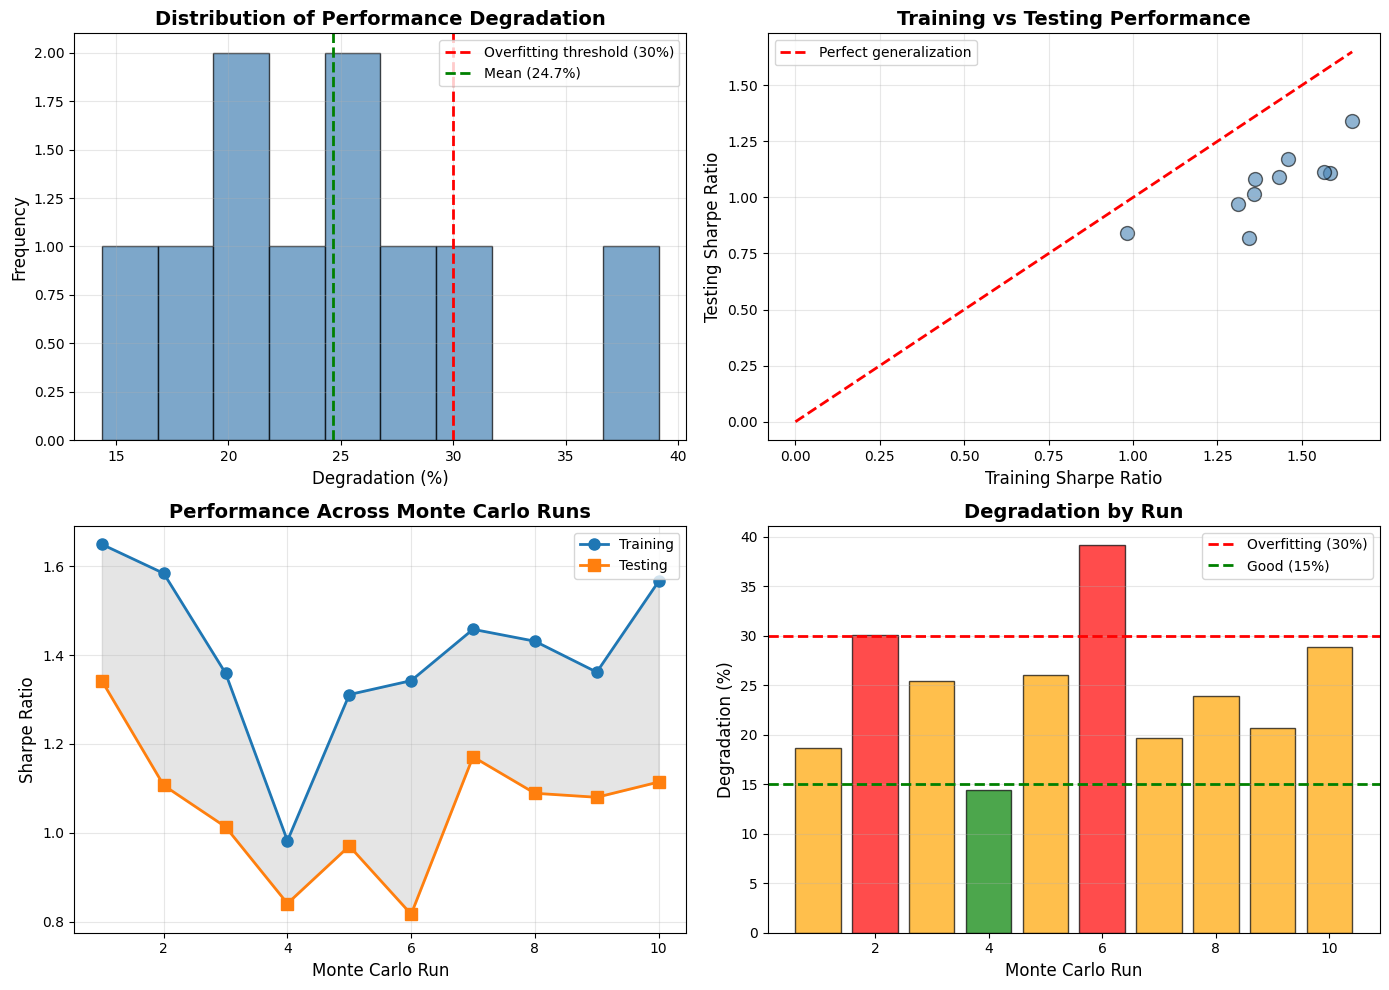


[OK] Visualization complete


In [7]:
# ==================== VISUALIZATION ====================

if len(results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].hist(df_results['degradation'] * 100, bins=10, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].axvline(x=30, color='r', linestyle='--', linewidth=2, label='Overfitting threshold (30%)')
    axes[0, 0].axvline(x=mean_deg * 100, color='g', linestyle='--', linewidth=2, label=f'Mean ({mean_deg*100:.1f}%)')
    axes[0, 0].set_xlabel('Degradation (%)', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title('Distribution of Performance Degradation', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].scatter(df_results['train_sharpe'], df_results['test_sharpe'], 
                       alpha=0.6, s=100, c='steelblue', edgecolors='black', linewidth=1)
    max_sharpe = max(df_results['train_sharpe'].max(), df_results['test_sharpe'].max())
    axes[0, 1].plot([0, max_sharpe], [0, max_sharpe], 'r--', linewidth=2, label='Perfect generalization')
    axes[0, 1].set_xlabel('Training Sharpe Ratio', fontsize=12)
    axes[0, 1].set_ylabel('Testing Sharpe Ratio', fontsize=12)
    axes[0, 1].set_title('Training vs Testing Performance', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(df_results['run'], df_results['train_sharpe'], 
                    marker='o', label='Training', linewidth=2, markersize=8)
    axes[1, 0].plot(df_results['run'], df_results['test_sharpe'], 
                    marker='s', label='Testing', linewidth=2, markersize=8)
    axes[1, 0].fill_between(df_results['run'], df_results['train_sharpe'], 
                            df_results['test_sharpe'], alpha=0.2, color='gray')
    axes[1, 0].set_xlabel('Monte Carlo Run', fontsize=12)
    axes[1, 0].set_ylabel('Sharpe Ratio', fontsize=12)
    axes[1, 0].set_title('Performance Across Monte Carlo Runs', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    colors = ['green' if d < 0.15 else 'orange' if d < 0.30 else 'red' 
              for d in df_results['degradation']]
    axes[1, 1].bar(df_results['run'], df_results['degradation'] * 100, 
                   color=colors, edgecolor='black', alpha=0.7)
    axes[1, 1].axhline(y=30, color='r', linestyle='--', linewidth=2, label='Overfitting (30%)')
    axes[1, 1].axhline(y=15, color='g', linestyle='--', linewidth=2, label='Good (15%)')
    axes[1, 1].set_xlabel('Monte Carlo Run', fontsize=12)
    axes[1, 1].set_ylabel('Degradation (%)', fontsize=12)
    axes[1, 1].set_title('Degradation by Run', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n[OK] Visualization complete")

In [8]:
# ==================== SAVE RESULTS ====================

if len(results) > 0:
    output_data = {
        'configuration': {
            'mode': 'LOCAL' if IS_LOCAL else 'QC_RESEARCH',
            'project_id': config['project_id'],
            'period': f"{config['total_period']['start'].date()} to {config['total_period']['end'].date()}",
            'train_test_split': config['train_test_split'],
            'monte_carlo_runs': config['monte_carlo_runs'],
            'parameters': config['parameters']
        },
        'summary': {
            'successful_runs': len(results),
            'failed_runs': len(errors),
            'mean_train_sharpe': float(mean_train),
            'mean_test_sharpe': float(mean_test),
            'mean_degradation': float(mean_deg),
            'std_degradation': float(std_deg),
            'pct_overfit': float(overfit_pct),
            'decision': decision,
            'reason': reason,
            'recommendation': recommendation
        },
        'recommended_parameters': recommended_params,
        'detailed_results': [
            {
                'run': r['run'],
                'train_period': f"{r['train_start'].date()} to {r['train_end'].date()}",
                'test_period': f"{r['test_start'].date()} to {r['test_end'].date()}",
                'train_sharpe': r['train_sharpe'],
                'test_sharpe': r['test_sharpe'],
                'degradation': r['degradation'],
                'best_params': r['best_params'],
                'test_metrics': r['test_metrics']
            }
            for r in results
        ],
        'errors': errors
    }
    
    mode_suffix = 'local' if IS_LOCAL else 'qc'
    output_filename = f"walkforward_results_{mode_suffix}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(output_filename, 'w') as f:
        json.dump(output_data, f, indent=2)
    
    print(f"\n[OK] Results saved to: {output_filename}")
    print(f"\n" + "="*60)
    print(f"MONTE CARLO WALK-FORWARD ANALYSIS COMPLETE ({'LOCAL TEST' if IS_LOCAL else 'QC RESEARCH'})")
    print("="*60)
    
    if IS_LOCAL:
        print("\nThis was a LOCAL TEST with SYNTHETIC data.")
        print("The logic has been validated.")
        print("Next: Upload to QC Research and enable real optimization/backtest calls.")
else:
    print("\n[ERROR] No results to save")


[OK] Results saved to: walkforward_results_local_20251110_094945.json

MONTE CARLO WALK-FORWARD ANALYSIS COMPLETE (LOCAL TEST)

This was a LOCAL TEST with SYNTHETIC data.
The logic has been validated.
Next: Upload to QC Research and enable real optimization/backtest calls.
